In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime


# Cargar datos desde CSV
df = pd.read_csv("data/clima_limpio_2024.csv")


In [2]:
# Convertir la columna 'fecha' a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')

# Filtrar por una ciudad (opcional)
df_ciudad = df[df['ciudad'] == 'Madrid']

# Ordenar los datos por fecha
df_ciudad = df_ciudad.sort_values('fecha')

# Imputar o eliminar valores faltantes
df_ciudad = df_ciudad.dropna()

# Eliminar unidades y convertir a números
df_ciudad['t_max'] = df_ciudad['t_max'].str.replace('°', '').astype(float)
df_ciudad['t_min'] = df_ciudad['t_min'].str.replace('°', '').astype(float)

# Limpiar precipitaciones, reemplazar comas por puntos y convertir a float
df_ciudad['precipitacion'] = df_ciudad['precipitacion'].str.replace(' mm', '').str.replace(',', '.').astype(float)

# Limpiar viento, eliminar ' Km/h' y convertir a float
df_ciudad['viento'] = df_ciudad['viento'].str.replace(' Km/h', '').astype(float)

# Limpiar humedad, eliminar '%' y convertir a float
df_ciudad['humedad'] = df_ciudad['humedad'].str.replace('%', '').astype(float)

# Verifica los cambios
print(df_ciudad.head())

# Seleccionar las columnas numéricas que usarás para la predicción
features = ['t_max', 't_min', 'precipitacion', 'viento', 'humedad']
data = df_ciudad[features].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

     ciudad      fecha  t_max  t_min  precipitacion  viento  humedad
366  Madrid 2024-01-01   12.5    6.0            0.5    10.2     51.5
367  Madrid 2024-01-02   12.2    5.7            0.2    11.3     58.2
368  Madrid 2024-01-03   11.2    4.7            0.1     9.8     61.5
369  Madrid 2024-01-04   12.0    4.8            2.4    12.3     67.8
370  Madrid 2024-01-05   11.0    4.3            0.3    13.8     54.8


In [3]:
# Crear secuencias de datos para LSTM
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    dates = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length, :2])  # Predicción de t_max y t_min
        dates.append(df_ciudad.iloc[i + seq_length]['fecha'])  # Fecha correspondiente

    return np.array(sequences), np.array(targets), np.array(dates)

SEQ_LENGTH = 30  # Usamos los últimos 30 días para predecir el siguiente
X, y, fechas = create_sequences(data_scaled, SEQ_LENGTH)

# Separar en conjunto de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
fechas_test = fechas[train_size:]


In [4]:
# Convertir a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


print("Forma de X_train:", X_train.shape)  # (n_samples, 30, 5)
print("Forma de y_train:", y_train.shape)  # (n_samples, 2)
print("Forma de X_test:", X_test.shape)  # (n_samples, 30, 5)
print("Forma de y_test:", y_test.shape)  # (n_samples, 2)

Forma de X_train: torch.Size([268, 30, 5])
Forma de y_train: torch.Size([268, 2])
Forma de X_test: torch.Size([68, 30, 5])
Forma de y_test: torch.Size([68, 2])


In [5]:
# Definir el modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hiperparámetros
input_size = 5  # Número de características
hidden_size = 50  # Número de neuronas en la capa oculta
num_layers = 2  # Capas de LSTM
output_size = 2  # Predicción de t_max y t_min
learning_rate = 0.001
num_epochs = 100
batch_size = 16

In [6]:
# Crear el modelo
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
print(model)

LSTMModel(
  (lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)


In [7]:
# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{num_epochs}], Pérdida: {loss.item():.6f}")

print("Entrenamiento completado.")


Época [10/100], Pérdida: 0.258557
Época [20/100], Pérdida: 0.098651
Época [30/100], Pérdida: 0.057495
Época [40/100], Pérdida: 0.036787
Época [50/100], Pérdida: 0.020463
Época [60/100], Pérdida: 0.007480
Época [70/100], Pérdida: 0.006817
Época [80/100], Pérdida: 0.004724
Época [90/100], Pérdida: 0.004522
Época [100/100], Pérdida: 0.004211
Entrenamiento completado.


In [9]:
# Evaluación del modelo
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Calcular el error MSE en el conjunto de prueba
test_loss = criterion(y_pred, y_test)
print(f"Pérdida en el conjunto de prueba: {test_loss.item():.6f}")

Pérdida en el conjunto de prueba: 0.004926


In [10]:
# Desnormalizar predicciones y valores reales
y_pred_actual = scaler.inverse_transform(np.hstack((y_pred.numpy(), np.zeros((y_pred.shape[0], data.shape[1] - 2)))))[:, :2]
y_test_actual = scaler.inverse_transform(np.hstack((y_test.numpy(), np.zeros((y_test.shape[0], data.shape[1] - 2)))))[:, :2]

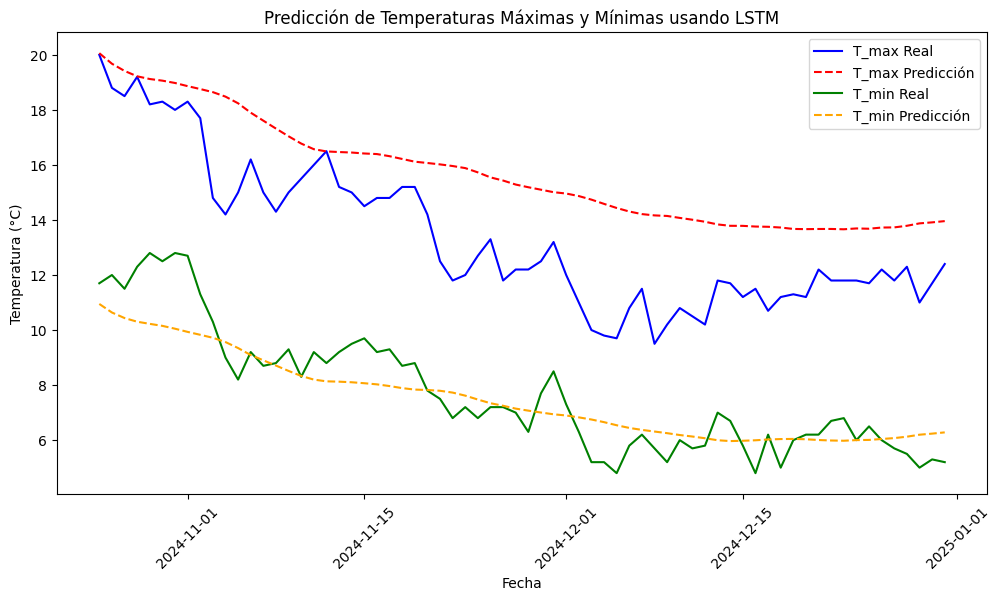

In [11]:
# Graficar predicciones vs valores reales con fechas
plt.figure(figsize=(12, 6))
plt.plot(fechas_test, y_test_actual[:, 0], label="T_max Real", color='blue')
plt.plot(fechas_test, y_pred_actual[:, 0], label="T_max Predicción", color='red', linestyle='dashed')
plt.plot(fechas_test, y_test_actual[:, 1], label="T_min Real", color='green')
plt.plot(fechas_test, y_pred_actual[:, 1], label="T_min Predicción", color='orange', linestyle='dashed')
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.title("Predicción de Temperaturas Máximas y Mínimas usando LSTM")
plt.xticks(rotation=45)
plt.show()